# Evaluate gridworld agents

In [28]:
import os
import json
import pickle
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import torch

from src.tabular.discrete_agent import DiscreteAgent
from src.env.gridworld import Gridworld
from src.visualization.gridworld import GridworldVis
from src.tabular.gridworld_experiment import load_ground_truth_agent
from src.tabular.utils import kl_divergence

In [50]:
def load_trained_agent(path):
    # load args
    with open(os.path.join(path, "args.json"), "rb") as f:
        arglist = json.load(f)

    # load state dict
    state_dict = torch.load(os.path.join(path, "model.pt"))
    agent_state_dict = {
        k.replace("agent.", ""): v for (k, v) in state_dict["model_state_dict"].items() if "agent." in k
    }
    
    state_dim = int(arglist["num_grids"] ** 2)
    act_dim = 5
    gamma = arglist["gamma"]
    alpha = arglist["alpha"]
    horizon = arglist["horizon"]
    agent = DiscreteAgent(state_dim, act_dim, gamma, alpha, horizon)

    agent.load_state_dict(agent_state_dict)
    
    # handle pil agents
    bonus =None
    if "state_marginal" in state_dict["model_state_dict"]:
        agent.pess_penalty = arglist["pess_penalty"]
        agent.state_marginal = state_dict["model_state_dict"]["state_marginal"]
        agent.bonus = agent.pess_penalty * torch.log(agent.state_marginal + 1e-6)
        with torch.no_grad():
            bonus = agent.pess_penalty * torch.log(agent.state_marginal + 1e-6)

    agent.plan(bonus)
    return agent

In [3]:
# load ground truth agents
num_grids = 5
true_agent_1 = load_ground_truth_agent(
    num_grids, "one_state", "one_goal", 1.
)
true_agent_2 = load_ground_truth_agent(
    num_grids, "one_state", "three_goals", 0.95
)
true_agent_3 = load_ground_truth_agent(
    num_grids, "uniform", "three_goals", 1/3
)

In [71]:
# load btom agents
exp_path = "../exp/gridworld/btom"

# sample
# agent_1 = load_trained_agent(
#     os.path.join(exp_path, "one_state_one_goal", "03-15-2023 22-20-19")
# )
# agent_2 = load_trained_agent(
#     os.path.join(exp_path, "one_state_three_goals", "03-15-2023 22-35-07")
# )
# agent_3 = load_trained_agent(
#     os.path.join(exp_path, "uniform_three_goals", "03-15-2023 22-07-54")
# )

# exact
# btom_agent_1 = load_trained_agent(
#     os.path.join(exp_path, "one_state_one_goal", "03-15-2023 17-03-30")
# )
# btom_agent_2 = load_trained_agent(
#     os.path.join(exp_path, "one_state_three_goals", "03-15-2023 17-16-54")
# )
# btom_agent_3 = load_trained_agent(
#     os.path.join(exp_path, "uniform_three_goals", "03-15-2023 16-46-41")
# )

# all data
# btom_agent_1 = load_trained_agent(
#     os.path.join(exp_path, "one_state_one_goal", "03-16-2023 15-28-14")
# )
# btom_agent_2 = load_trained_agent(
#     os.path.join(exp_path, "one_state_three_goals", "03-16-2023 16-02-24")
# )
# btom_agent_3 = load_trained_agent(
#     os.path.join(exp_path, "uniform_three_goals", "03-16-2023 16-36-50")
# )

# gamma = 0.7
btom_agent_1 = load_trained_agent(
    os.path.join(exp_path, "one_state_one_goal", "03-17-2023 15-49-31")
)
btom_agent_2 = load_trained_agent(
    os.path.join(exp_path, "one_state_three_goals", "03-17-2023 15-57-18")
)
btom_agent_3 = load_trained_agent(
    os.path.join(exp_path, "uniform_three_goals", "03-17-2023 16-05-17")
)

In [43]:
# load irl agents
exp_path = "../exp/gridworld/irl"

# exact
# irl_agent_1 = load_trained_agent(
#     os.path.join(exp_path, "one_state_one_goal", "03-16-2023 12-21-05")
# )
# irl_agent_2 = load_trained_agent(
#     os.path.join(exp_path, "one_state_three_goals", "03-16-2023 12-21-26")
# )
# irl_agent_3 = load_trained_agent(
#     os.path.join(exp_path, "uniform_three_goals", "03-16-2023 12-21-46")
# )

# all data
irl_agent_1 = load_trained_agent(
    os.path.join(exp_path, "one_state_one_goal", "03-16-2023 17-30-39")
)
irl_agent_2 = load_trained_agent(
    os.path.join(exp_path, "one_state_three_goals", "03-16-2023 17-31-05")
)
irl_agent_3 = load_trained_agent(
    os.path.join(exp_path, "uniform_three_goals", "03-16-2023 17-31-32")
)

In [51]:
# load pil agents
exp_path = "../exp/gridworld/pil"

# exact
# pil_agent_1 = load_trained_agent(
#     os.path.join(exp_path, "one_state_one_goal", "03-16-2023 12-31-50")
# )
# pil_agent_2 = load_trained_agent(
#     os.path.join(exp_path, "one_state_three_goals", "03-16-2023 12-32-10")
# )
# pil_agent_3 = load_trained_agent(
#     os.path.join(exp_path, "uniform_three_goals", "03-16-2023 12-32-31")
# )

# all data
pil_agent_1 = load_trained_agent(
    os.path.join(exp_path, "one_state_one_goal", "03-16-2023 17-33-49")
)
pil_agent_2 = load_trained_agent(
    os.path.join(exp_path, "one_state_three_goals", "03-16-2023 17-34-17")
)
pil_agent_3 = load_trained_agent(
    os.path.join(exp_path, "uniform_three_goals", "03-16-2023 17-34-45")
)

In [7]:
# init visualizer
vis = GridworldVis(Gridworld(num_grids))

## Eval IRL agents

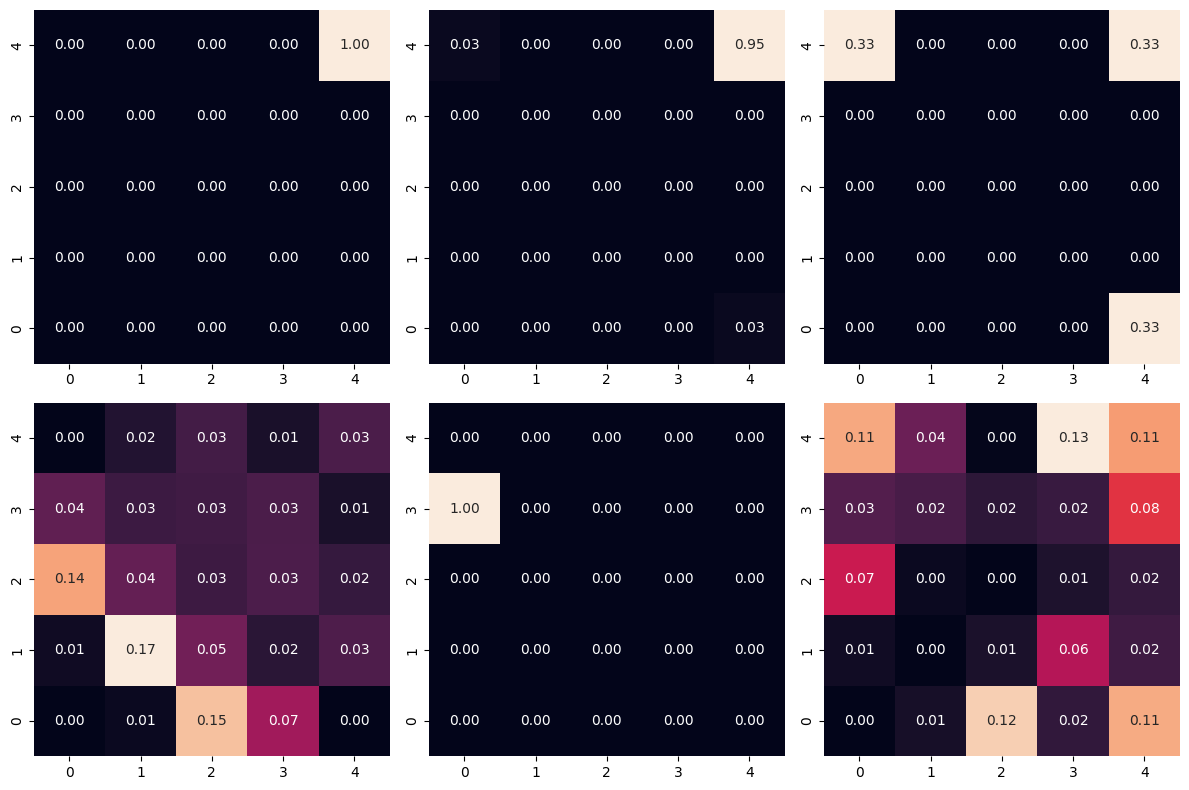

In [44]:
# plot rewards
fig, ax = plt.subplots(2, 3, figsize=(12, 8))
# plot true agents
vis.plot_value_map(torch.softmax(true_agent_1.log_target, dim=-1).data, ax[0, 0])
vis.plot_value_map(torch.softmax(true_agent_2.log_target, dim=-1).data, ax[0, 1])
vis.plot_value_map(torch.softmax(true_agent_3.log_target, dim=-1).data, ax[0, 2])

# plot trained agents
vis.plot_value_map(torch.softmax(irl_agent_1.log_target, dim=-1).data, ax[1, 0])
vis.plot_value_map(torch.softmax(irl_agent_2.log_target, dim=-1).data, ax[1, 1])
vis.plot_value_map(torch.softmax(irl_agent_3.log_target, dim=-1).data, ax[1, 2])

plt.tight_layout()
plt.show()

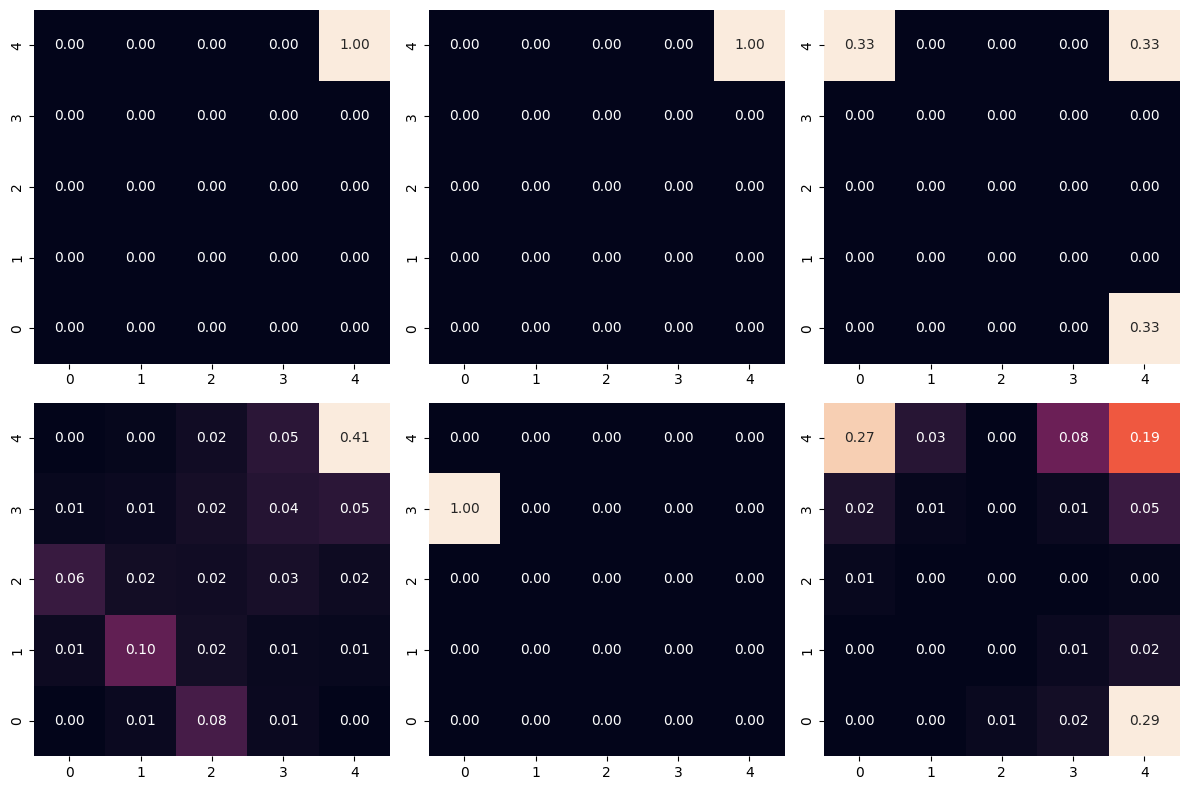

In [45]:
# plot values
fig, ax = plt.subplots(2, 3, figsize=(12, 8))
# plot true agents
# vis.plot_value_map(true_agent_1.v, ax[0, 0])
# vis.plot_value_map(true_agent_2.v, ax[0, 1])
# vis.plot_value_map(true_agent_3.v, ax[0, 2])

# # plot trained agents
# vis.plot_value_map(irl_agent_1.v, ax[1, 0])
# vis.plot_value_map(irl_agent_2.v, ax[1, 1])
# vis.plot_value_map(irl_agent_3.v, ax[1, 2])

vis.plot_value_map(torch.softmax(true_agent_1.v, dim=-1), ax[0, 0])
vis.plot_value_map(torch.softmax(true_agent_2.v, dim=-1), ax[0, 1])
vis.plot_value_map(torch.softmax(true_agent_3.v, dim=-1), ax[0, 2])

# plot trained agents
vis.plot_value_map(torch.softmax(irl_agent_1.v, dim=-1), ax[1, 0])
vis.plot_value_map(torch.softmax(irl_agent_2.v, dim=-1), ax[1, 1])
vis.plot_value_map(torch.softmax(irl_agent_3.v, dim=-1), ax[1, 2])

plt.tight_layout()
plt.show()

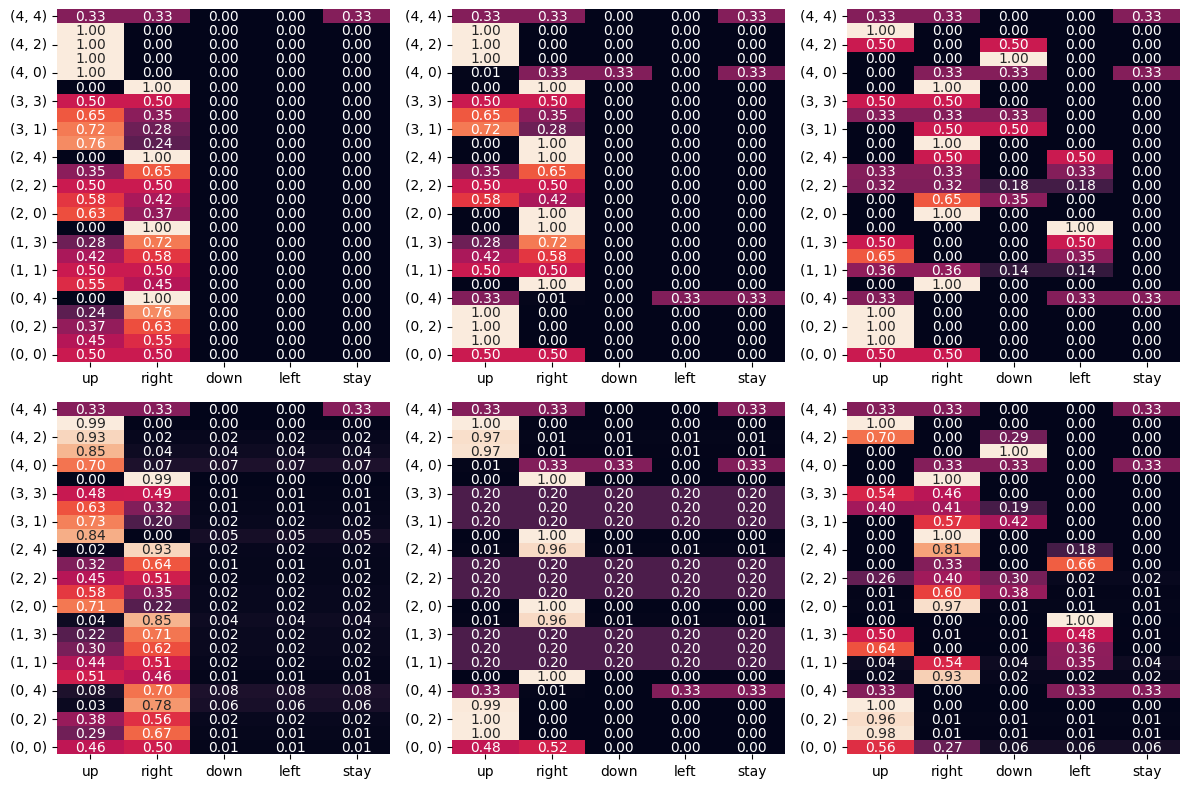

In [13]:
# plot policies
fig, ax = plt.subplots(2, 3, figsize=(12, 8))
# plot true agents
vis.plot_state_action(true_agent_1.pi, ax[0, 0])
vis.plot_state_action(true_agent_2.pi, ax[0, 1])
vis.plot_state_action(true_agent_3.pi, ax[0, 2])

# plot trained agents
vis.plot_state_action(irl_agent_1.pi, ax[1, 0])
vis.plot_state_action(irl_agent_2.pi, ax[1, 1])
vis.plot_state_action(irl_agent_3.pi, ax[1, 2])

plt.tight_layout()
plt.show()

In [16]:
print("data 1 kl", kl_divergence(true_agent_1.pi, irl_agent_1.pi).mean().data.item())
print("data 2 kl", kl_divergence(true_agent_2.pi, irl_agent_2.pi).mean().data.item())
print("data 3 kl", kl_divergence(true_agent_3.pi, irl_agent_3.pi).mean().data.item())

data 1 kl 0.21773381531238556
data 2 kl 0.3483491837978363
data 3 kl 0.13856478035449982


## Eval PIL agents

In [58]:
print(pil_agent_1.reward())
print(pil_agent_1.bonus)

tensor([-56.7056,  -5.8322,  -1.9881,  -2.1050, -23.4092,  -6.0731,  -2.7827,
         -3.7251,  -3.7046,  -3.0687,  -1.8748,  -3.6136,  -4.4441,  -4.1538,
         -3.5191,  -1.7384,  -4.0507,  -3.9901,  -4.3400,  -5.3235, -11.0448,
         -2.4929,  -3.7251,  -5.3247,  -8.6587], grad_fn=<LogSoftmaxBackward0>)
tensor([-3.9086, -4.5595, -5.4567, -6.4371, -7.6678, -4.6459, -4.4567, -4.7954,
        -5.3815, -6.4797, -5.4884, -4.7874, -4.6118, -4.8035, -5.4259, -6.3194,
        -5.4109, -4.7874, -4.4918, -4.6051, -7.5345, -6.2480, -5.4259, -4.6051,
        -0.1745])


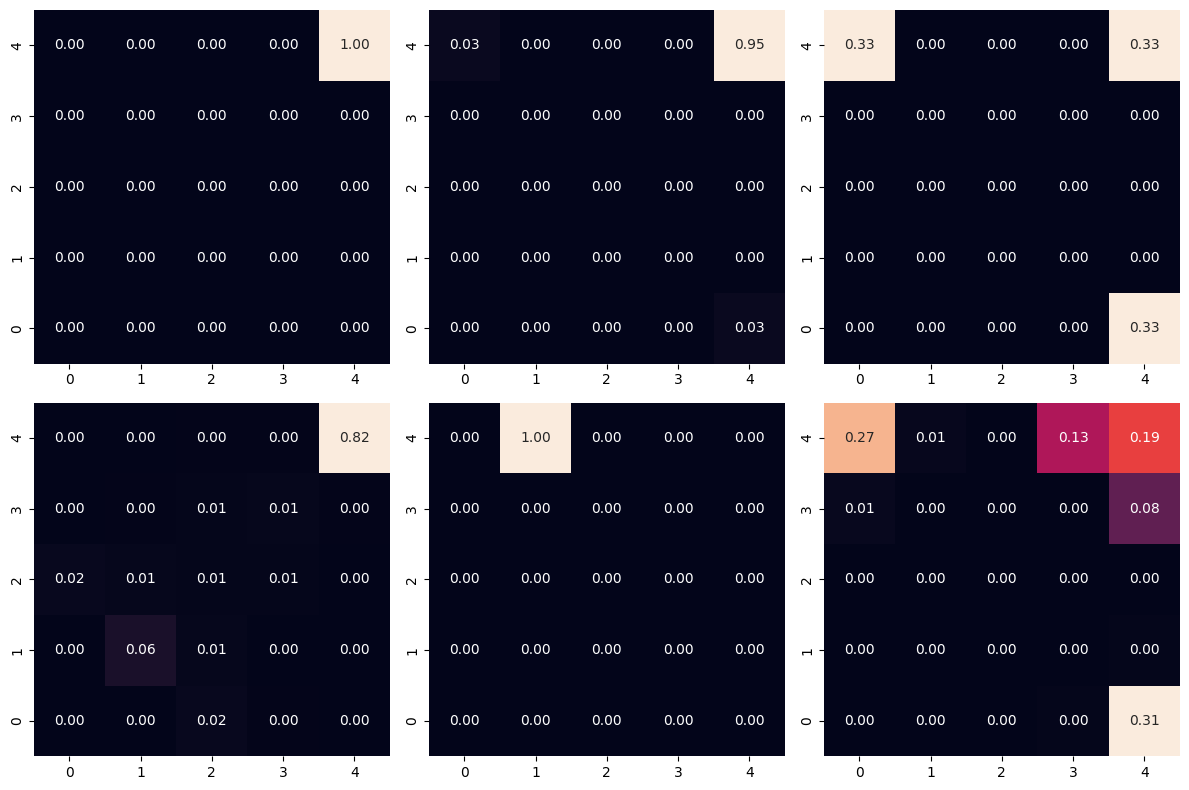

In [67]:
# plot rewards
fig, ax = plt.subplots(2, 3, figsize=(12, 8))
# plot true agents
vis.plot_value_map(torch.softmax(true_agent_1.log_target, dim=-1).data, ax[0, 0])
vis.plot_value_map(torch.softmax(true_agent_2.log_target, dim=-1).data, ax[0, 1])
vis.plot_value_map(torch.softmax(true_agent_3.log_target, dim=-1).data, ax[0, 2])

# plot trained agents
# vis.plot_value_map(torch.softmax(pil_agent_1.log_target, dim=-1).data, ax[1, 0])
# vis.plot_value_map(torch.softmax(pil_agent_2.log_target, dim=-1).data, ax[1, 1])
# vis.plot_value_map(torch.softmax(pil_agent_3.log_target, dim=-1).data, ax[1, 2])

vis.plot_value_map(torch.softmax(pil_agent_1.reward() + 2 * pil_agent_1.state_marginal.log(), dim=-1).data, ax[1, 0])
vis.plot_value_map(torch.softmax(pil_agent_2.reward() + 2 * pil_agent_2.state_marginal.log(), dim=-1).data, ax[1, 1])
vis.plot_value_map(torch.softmax(pil_agent_3.reward() + 2 * pil_agent_3.state_marginal.log(), dim=-1).data, ax[1, 2])

plt.tight_layout()
plt.show()

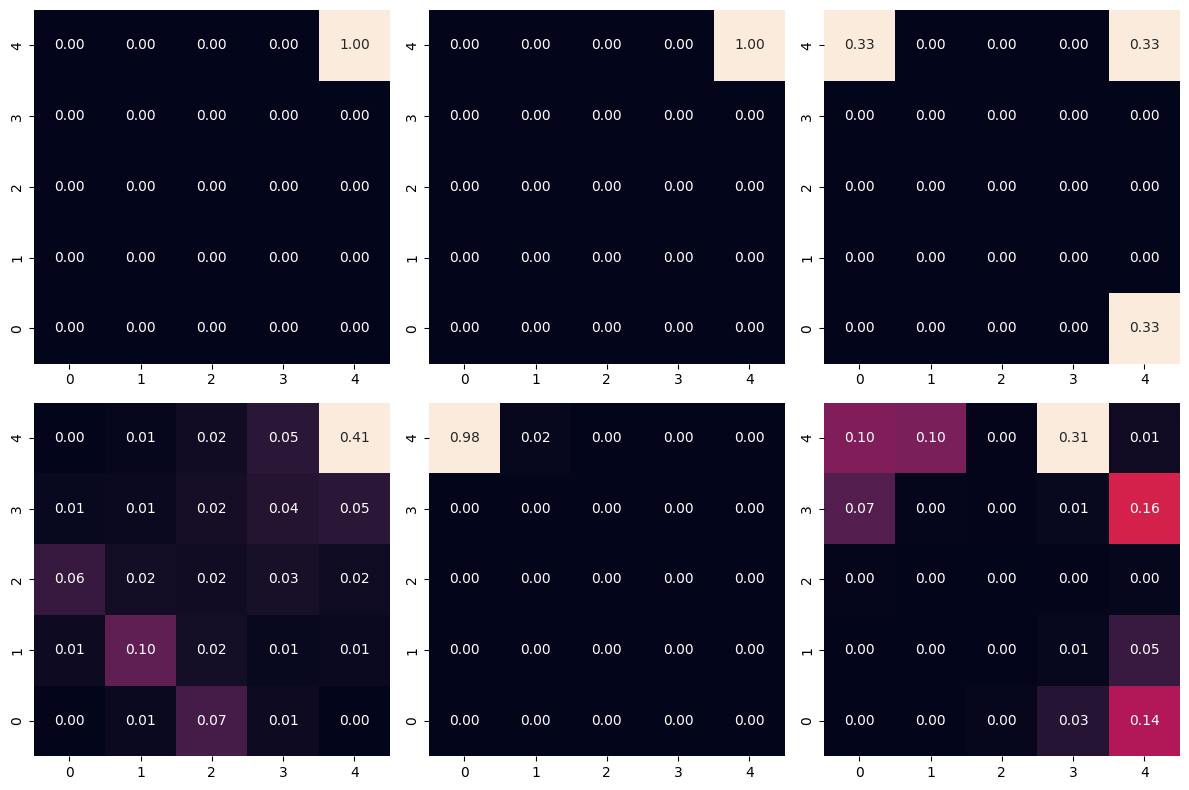

In [68]:
# plot values
fig, ax = plt.subplots(2, 3, figsize=(12, 8))
# plot true agents
# vis.plot_value_map(true_agent_1.v, ax[0, 0])
# vis.plot_value_map(true_agent_2.v, ax[0, 1])
# vis.plot_value_map(true_agent_3.v, ax[0, 2])

# # plot trained agents
# vis.plot_value_map(pil_agent_1.v, ax[1, 0])
# vis.plot_value_map(pil_agent_2.v, ax[1, 1])
# vis.plot_value_map(pil_agent_3.v, ax[1, 2])

vis.plot_value_map(torch.softmax(true_agent_1.v, dim=-1), ax[0, 0])
vis.plot_value_map(torch.softmax(true_agent_2.v, dim=-1), ax[0, 1])
vis.plot_value_map(torch.softmax(true_agent_3.v, dim=-1), ax[0, 2])

# plot trained agents
vis.plot_value_map(torch.softmax(pil_agent_1.v, dim=-1), ax[1, 0])
vis.plot_value_map(torch.softmax(pil_agent_2.v, dim=-1), ax[1, 1])
vis.plot_value_map(torch.softmax(pil_agent_3.v, dim=-1), ax[1, 2])

plt.tight_layout()
plt.show()

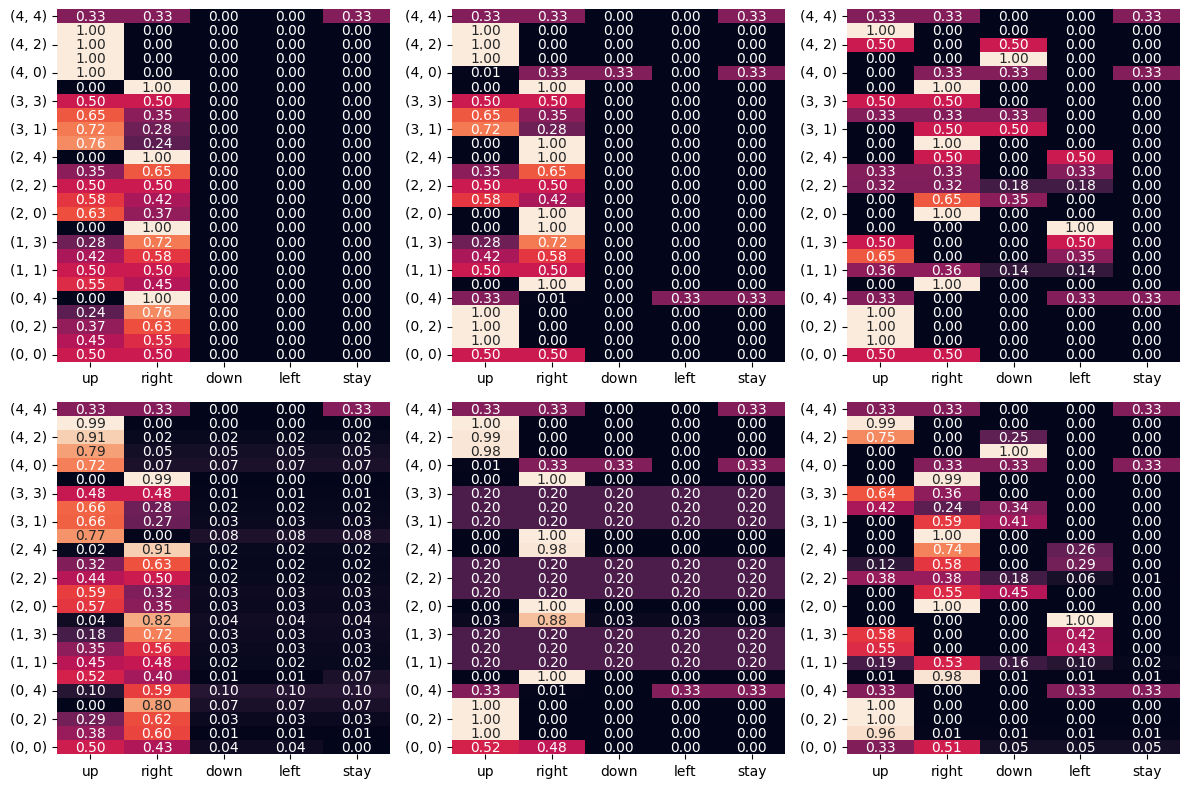

In [69]:
# plot policies
fig, ax = plt.subplots(2, 3, figsize=(12, 8))
# plot true agents
vis.plot_state_action(true_agent_1.pi, ax[0, 0])
vis.plot_state_action(true_agent_2.pi, ax[0, 1])
vis.plot_state_action(true_agent_3.pi, ax[0, 2])

# plot trained agents
vis.plot_state_action(pil_agent_1.pi, ax[1, 0])
vis.plot_state_action(pil_agent_2.pi, ax[1, 1])
vis.plot_state_action(pil_agent_3.pi, ax[1, 2])

plt.tight_layout()
plt.show()

In [20]:
print("data 1 kl", kl_divergence(true_agent_1.pi, pil_agent_1.pi).mean().data.item())
print("data 2 kl", kl_divergence(true_agent_2.pi, pil_agent_2.pi).mean().data.item())
print("data 3 kl", kl_divergence(true_agent_3.pi, pil_agent_3.pi).mean().data.item())

data 1 kl 0.17396211624145508
data 2 kl 0.34893348813056946
data 3 kl 0.22855621576309204


## Eval BTOM agents

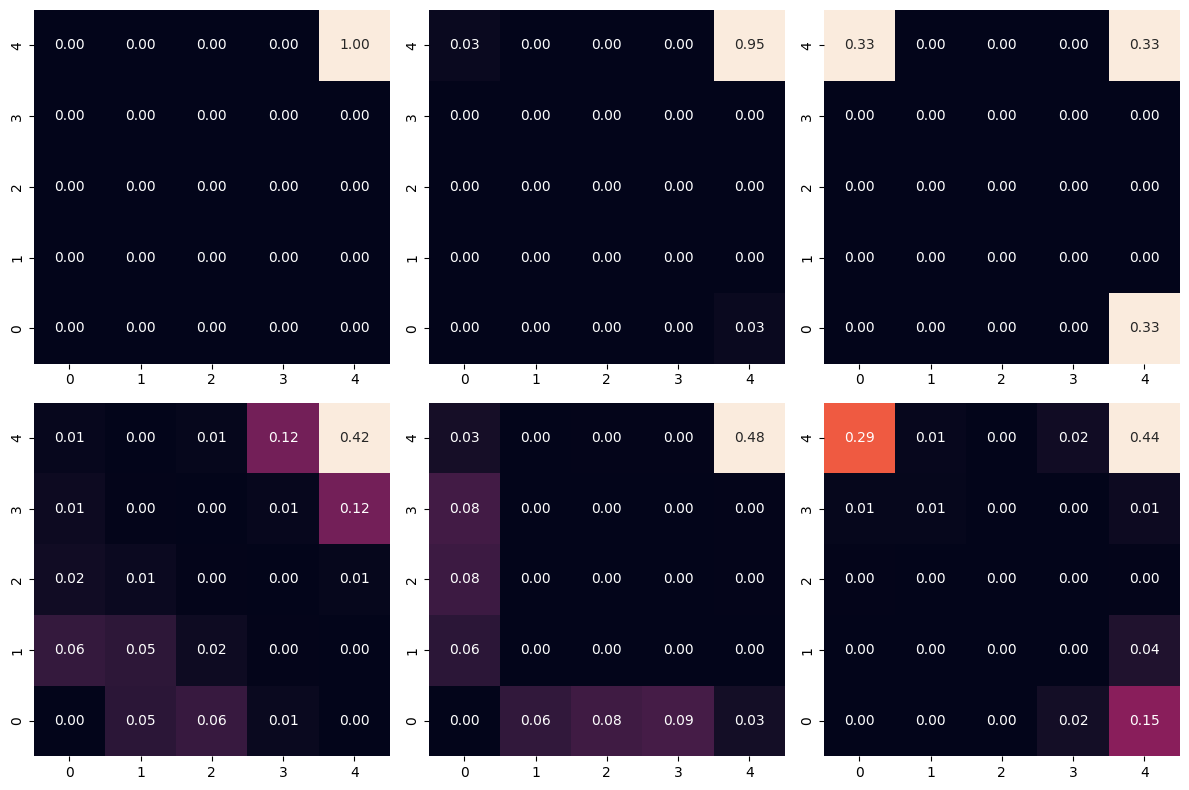

In [72]:
# plot rewards
fig, ax = plt.subplots(2, 3, figsize=(12, 8))
# plot true agents
vis.plot_value_map(torch.softmax(true_agent_1.log_target, dim=-1).data, ax[0, 0])
vis.plot_value_map(torch.softmax(true_agent_2.log_target, dim=-1).data, ax[0, 1])
vis.plot_value_map(torch.softmax(true_agent_3.log_target, dim=-1).data, ax[0, 2])

# plot trained agents
vis.plot_value_map(torch.softmax(btom_agent_1.log_target, dim=-1).data, ax[1, 0])
vis.plot_value_map(torch.softmax(btom_agent_2.log_target, dim=-1).data, ax[1, 1])
vis.plot_value_map(torch.softmax(btom_agent_3.log_target, dim=-1).data, ax[1, 2])

plt.tight_layout()
plt.show()

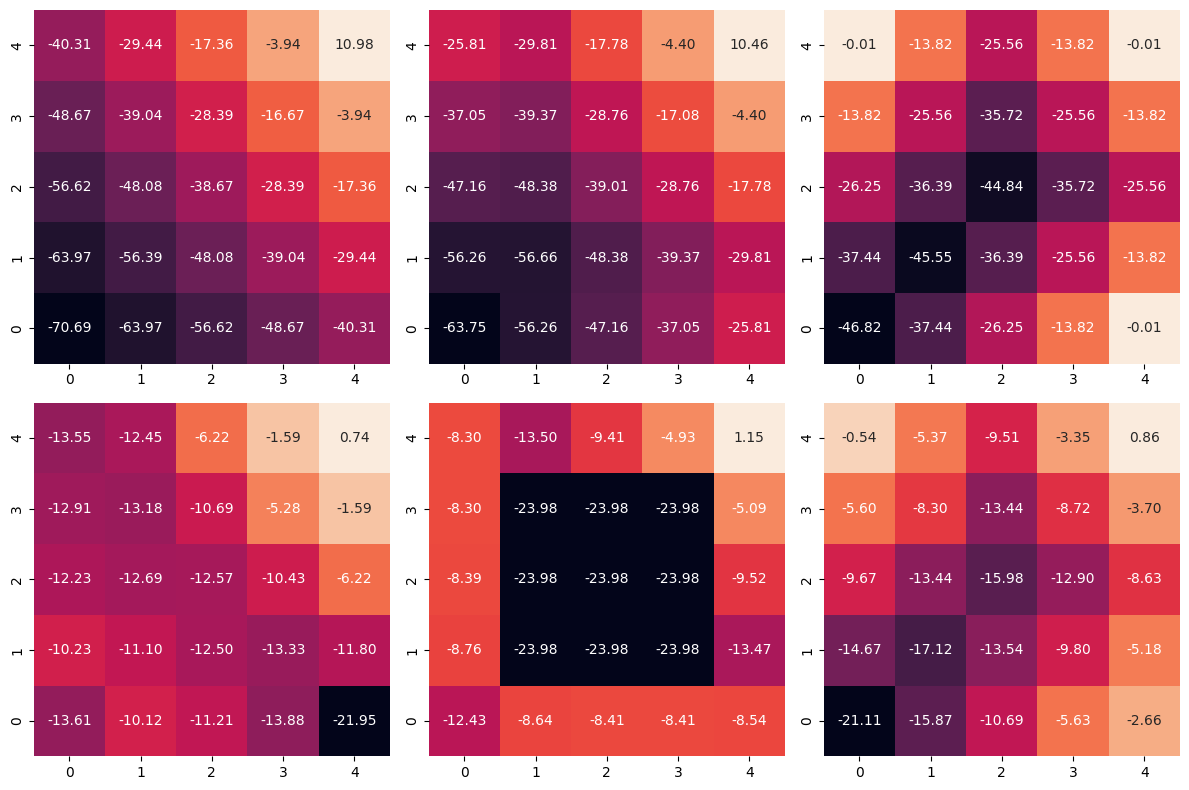

In [73]:
# plot values
fig, ax = plt.subplots(2, 3, figsize=(12, 8))
# plot true agents
vis.plot_value_map(true_agent_1.v, ax[0, 0])
vis.plot_value_map(true_agent_2.v, ax[0, 1])
vis.plot_value_map(true_agent_3.v, ax[0, 2])

# plot trained agents
vis.plot_value_map(btom_agent_1.v, ax[1, 0])
vis.plot_value_map(btom_agent_2.v, ax[1, 1])
vis.plot_value_map(btom_agent_3.v, ax[1, 2])

# vis.plot_value_map(torch.softmax(true_agent_1.v, dim=-1), ax[0, 0])
# vis.plot_value_map(torch.softmax(true_agent_2.v, dim=-1), ax[0, 1])
# vis.plot_value_map(torch.softmax(true_agent_3.v, dim=-1), ax[0, 2])

# # plot trained agents
# vis.plot_value_map(torch.softmax(btom_agent_1.v, dim=-1), ax[1, 0])
# vis.plot_value_map(torch.softmax(btom_agent_2.v, dim=-1), ax[1, 1])
# vis.plot_value_map(torch.softmax(btom_agent_3.v, dim=-1), ax[1, 2])

plt.tight_layout()
plt.show()

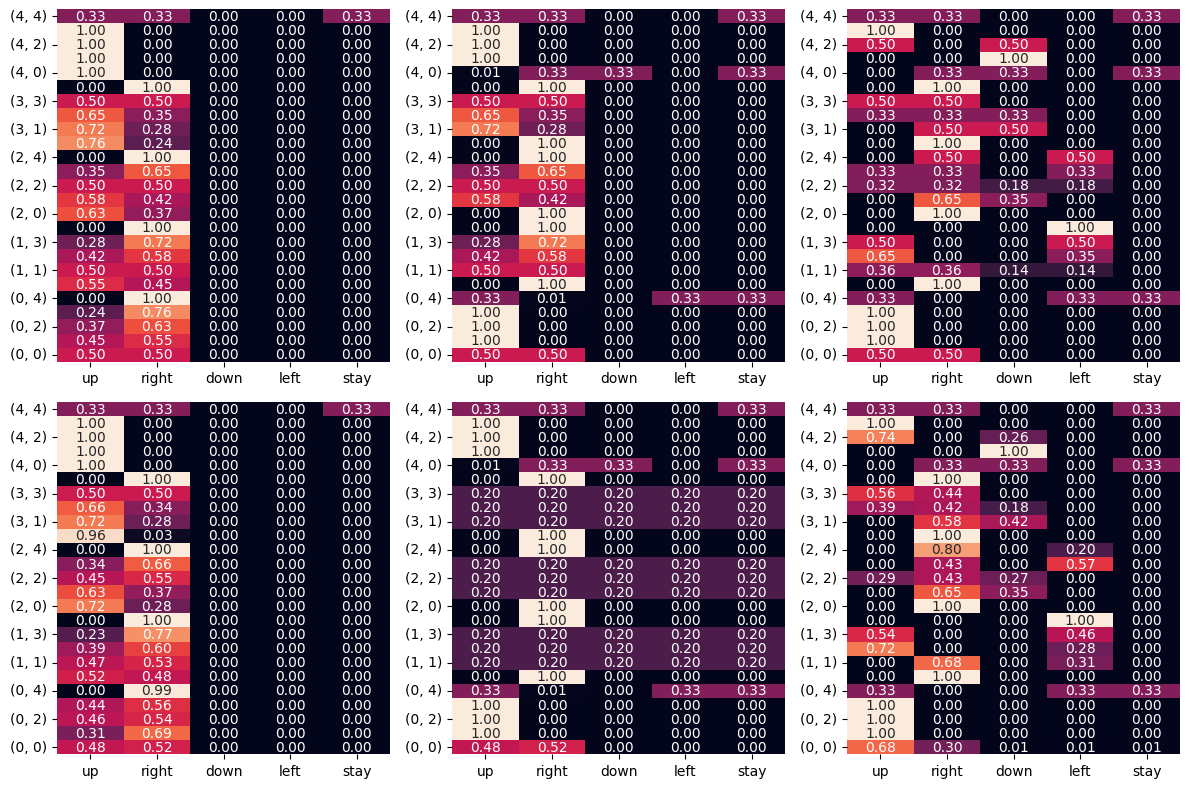

In [74]:
# plot policies
fig, ax = plt.subplots(2, 3, figsize=(12, 8))
# plot true agents
vis.plot_state_action(true_agent_1.pi, ax[0, 0])
vis.plot_state_action(true_agent_2.pi, ax[0, 1])
vis.plot_state_action(true_agent_3.pi, ax[0, 2])

# plot trained agents
vis.plot_state_action(btom_agent_1.pi, ax[1, 0])
vis.plot_state_action(btom_agent_2.pi, ax[1, 1])
vis.plot_state_action(btom_agent_3.pi, ax[1, 2])

plt.tight_layout()
plt.show()

In [24]:
print("data 1 kl", kl_divergence(true_agent_1.pi, btom_agent_1.pi).mean().data.item())
print("data 2 kl", kl_divergence(true_agent_2.pi, btom_agent_2.pi).mean().data.item())
print("data 3 kl", kl_divergence(true_agent_3.pi, btom_agent_3.pi).mean().data.item())

data 1 kl 0.008843451738357544
data 2 kl 0.34273993968963623
data 3 kl 0.23871245980262756


## Compare approaches

In [29]:
irl_pi_kl = [
    kl_divergence(true_agent_1.pi, irl_agent_1.pi).mean().data.item(),
    kl_divergence(true_agent_2.pi, irl_agent_2.pi).mean().data.item(),
    kl_divergence(true_agent_3.pi, irl_agent_3.pi).mean().data.item()
]
pil_pi_kl = [
    kl_divergence(true_agent_1.pi, pil_agent_1.pi).mean().data.item(),
    kl_divergence(true_agent_2.pi, pil_agent_2.pi).mean().data.item(),
    kl_divergence(true_agent_3.pi, pil_agent_3.pi).mean().data.item()
]
btom_pi_kl = [
    kl_divergence(true_agent_1.pi, btom_agent_1.pi).mean().data.item(),
    kl_divergence(true_agent_2.pi, btom_agent_2.pi).mean().data.item(),
    kl_divergence(true_agent_3.pi, btom_agent_3.pi).mean().data.item()
]

pi_kl = np.array([irl_pi_kl, pil_pi_kl, btom_pi_kl])
df_pi_kl = pd.DataFrame(
    pi_kl, 
    columns=["one_state_one_goal", "one_state_three_goals", "uniform_three_goals"],
    index=["irl", "pil", 'btom']
)
df_pi_kl

,one_state_one_goal,one_state_three_goals,uniform_three_goals
irl,0.217734,0.348349,0.138565
pil,0.173962,0.348933,0.228556
btom,0.008843,0.342740,0.238712


In [31]:
irl_v_error = [
    torch.abs(true_agent_1.v - irl_agent_1.v).mean().data.item(),
    torch.abs(true_agent_2.v - irl_agent_2.v).mean().data.item(),
    torch.abs(true_agent_3.v - irl_agent_3.v).mean().data.item(),
]
pil_v_error = [
    torch.abs(true_agent_1.v - pil_agent_1.v).mean().data.item(),
    torch.abs(true_agent_2.v - pil_agent_2.v).mean().data.item(),
    torch.abs(true_agent_3.v - pil_agent_3.v).mean().data.item(),
]
btom_v_error = [
    torch.abs(true_agent_1.v - btom_agent_1.v).mean().data.item(),
    torch.abs(true_agent_2.v - btom_agent_2.v).mean().data.item(),
    torch.abs(true_agent_3.v - btom_agent_3.v).mean().data.item(),
]
v_error = np.array([irl_v_error, pil_v_error, btom_v_error])
df_v_error = pd.DataFrame(
    v_error, 
    columns=["one_state_one_goal", "one_state_three_goals", "uniform_three_goals"],
    index=["irl", "pil", 'btom']
)
df_v_error

,one_state_one_goal,one_state_three_goals,uniform_three_goals
irl,18.663832,125.974983,8.992265
pil,49.623035,462.373322,108.443535
btom,25.350752,15.832130,12.299186


In [36]:
with torch.no_grad():
    true_agent_1_t_dist = torch.softmax(true_agent_1.log_target, dim=-1)
    true_agent_2_t_dist = torch.softmax(true_agent_2.log_target, dim=-1)
    true_agent_3_t_dist = torch.softmax(true_agent_3.log_target, dim=-1)

    irl_agent_1_t_dist = torch.softmax(irl_agent_1.log_target, dim=-1)
    irl_agent_2_t_dist = torch.softmax(irl_agent_2.log_target, dim=-1)
    irl_agent_3_t_dist = torch.softmax(irl_agent_3.log_target, dim=-1)

    pil_agent_1_t_dist = torch.softmax(pil_agent_1.log_target, dim=-1)
    pil_agent_2_t_dist = torch.softmax(pil_agent_2.log_target, dim=-1)
    pil_agent_3_t_dist = torch.softmax(pil_agent_3.log_target, dim=-1)

    btom_agent_1_t_dist = torch.softmax(btom_agent_1.log_target, dim=-1)
    btom_agent_2_t_dist = torch.softmax(btom_agent_2.log_target, dim=-1)
    btom_agent_3_t_dist = torch.softmax(btom_agent_3.log_target, dim=-1)

irl_t_error = [
    kl_divergence(true_agent_1_t_dist, irl_agent_1_t_dist).mean().data.item(),
    kl_divergence(true_agent_2_t_dist, irl_agent_2_t_dist).mean().data.item(),
    kl_divergence(true_agent_3_t_dist, irl_agent_3_t_dist).mean().data.item(),
]
pil_t_error = [
    kl_divergence(true_agent_1_t_dist, pil_agent_1_t_dist).mean().data.item(),
    kl_divergence(true_agent_2_t_dist, pil_agent_2_t_dist).mean().data.item(),
    kl_divergence(true_agent_3_t_dist, pil_agent_3_t_dist).mean().data.item(),
]
btom_t_error = [
    kl_divergence(true_agent_1_t_dist, btom_agent_1_t_dist).mean().data.item(),
    kl_divergence(true_agent_2_t_dist, btom_agent_2_t_dist).mean().data.item(),
    kl_divergence(true_agent_3_t_dist, btom_agent_3_t_dist).mean().data.item(),
]
t_error = np.array([irl_t_error, pil_t_error, btom_t_error])
df_t_error = pd.DataFrame(
    t_error, 
    columns=["one_state_one_goal", "one_state_three_goals", "uniform_three_goals"],
    index=["irl", "pil", 'btom']
)
df_t_error

,one_state_one_goal,one_state_three_goals,uniform_three_goals
irl,3.180750,13.495710,1.707166
pil,8.863005,13.582019,11.026879
btom,0.884453,2.525275,0.848665


In [35]:
true_agent_1_v_dist = torch.softmax(true_agent_1.v, dim=-1)
true_agent_2_v_dist = torch.softmax(true_agent_2.v, dim=-1)
true_agent_3_v_dist = torch.softmax(true_agent_3.v, dim=-1)

irl_agent_1_v_dist = torch.softmax(irl_agent_1.v, dim=-1)
irl_agent_2_v_dist = torch.softmax(irl_agent_2.v, dim=-1)
irl_agent_3_v_dist = torch.softmax(irl_agent_3.v, dim=-1)

pil_agent_1_v_dist = torch.softmax(pil_agent_1.v, dim=-1)
pil_agent_2_v_dist = torch.softmax(pil_agent_2.v, dim=-1)
pil_agent_3_v_dist = torch.softmax(pil_agent_3.v, dim=-1)

btom_agent_1_v_dist = torch.softmax(btom_agent_1.v, dim=-1)
btom_agent_2_v_dist = torch.softmax(btom_agent_2.v, dim=-1)
btom_agent_3_v_dist = torch.softmax(btom_agent_3.v, dim=-1)

irl_v_error = [
    kl_divergence(true_agent_1_v_dist, irl_agent_1_v_dist).mean().data.item(),
    kl_divergence(true_agent_2_v_dist, irl_agent_2_v_dist).mean().data.item(),
    kl_divergence(true_agent_3_v_dist, irl_agent_3_v_dist).mean().data.item(),
]
pil_v_error = [
    kl_divergence(true_agent_1_v_dist, pil_agent_1_v_dist).mean().data.item(),
    kl_divergence(true_agent_2_v_dist, pil_agent_2_v_dist).mean().data.item(),
    kl_divergence(true_agent_3_v_dist, pil_agent_3_v_dist).mean().data.item(),
]
btom_v_error = [
    kl_divergence(true_agent_1_v_dist, btom_agent_1_v_dist).mean().data.item(),
    kl_divergence(true_agent_2_v_dist, btom_agent_2_v_dist).mean().data.item(),
    kl_divergence(true_agent_3_v_dist, btom_agent_3_v_dist).mean().data.item(),
]
v_error = np.array([irl_v_error, pil_v_error, btom_v_error])
df_v_error = pd.DataFrame(
    v_error, 
    columns=["one_state_one_goal", "one_state_three_goals", "uniform_three_goals"],
    index=["irl", "pil", 'btom']
)
df_v_error

,one_state_one_goal,one_state_three_goals,uniform_three_goals
irl,0.799768,13.212550,0.286067
pil,0.822330,13.815501,2.454256
btom,0.236612,1.085099,0.682123


## Analyze BTOM learned dynamics

In [48]:
def plot_transition_row(transition, ax, model_name, a_labels, vmin=0., vmax=1., cmap="Greys"):
    for i in range(len(transition)):
        sns.heatmap(
            transition[i], vmin=vmin, vmax=vmax, annot=False, cbar=False, cmap=cmap, ax=ax[i]
        )
        ax[i].set_title(f"{model_name}, a={a_labels[i]}")

def plot_transitions(transitions, model_names, s_labels, a_labels, ax):
    for i, transition in enumerate(transitions):
        plot_transition_row(transition, ax[i, :], model_names[i], a_labels)
    
    for i in range(len(a_labels)):
        ax[-1, i].set_xticklabels(
            [tuple(s_labels[int(l - 0.5)]) for l in ax[0, 0].get_xticks()],
            rotation=45
        )
        ax[-1, i].set_xlabel("Next state")

    for j in range(len(ax)):
        ax[j, 0].set_yticklabels(
            [tuple(s_labels[int(l - 0.5)]) for l in ax[0, 0].get_yticks()],
            rotation=0
        )
        ax[j, 0].set_ylabel("State")

    plt.tight_layout()

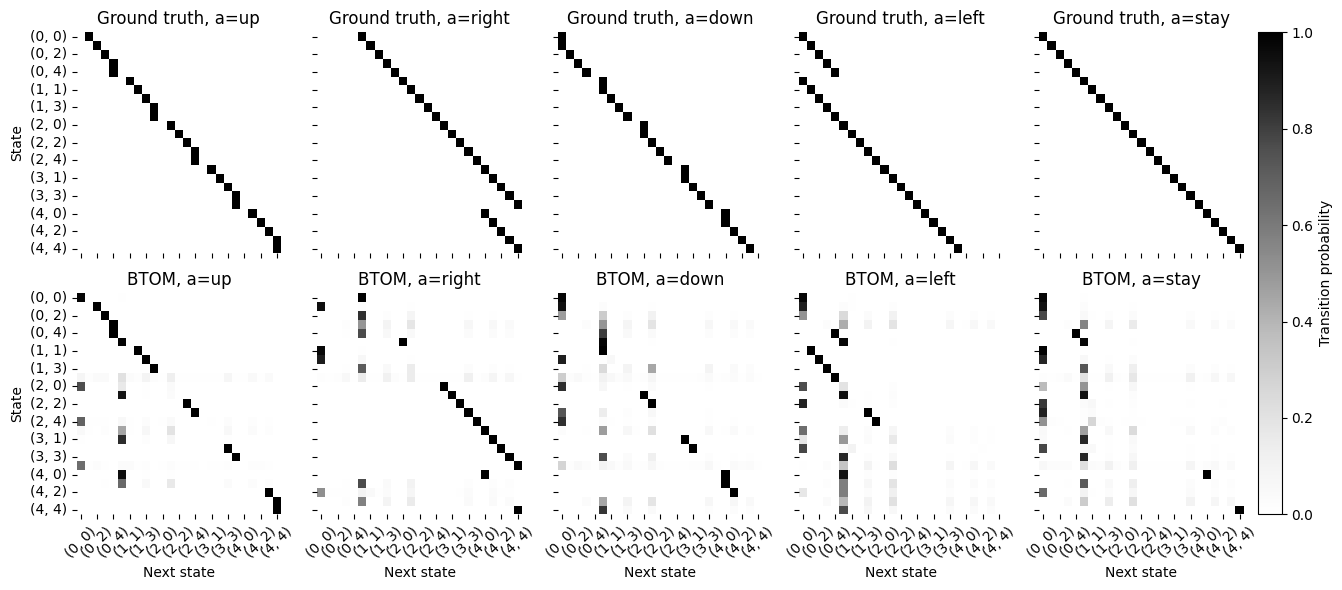

In [103]:
# fig, ax = plt.subplots(2, act_dim, figsize=(15, 6), sharex=True, sharey=True)
# plot_transitions(
#     [true_transition, transition],
#     ["Ground truth", "BTOM"], 
#     env.state2pos, env.a_labels, ax
# )
# fig.colorbar(
#     ax[-1, -1].collections[0], ax=ax.ravel().tolist(), pad=0.01, label="Transition probability"
# )
# plt.show()